In [1]:
# !pip install diffusers accelerate transformers qrcode denku

In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '7' ## select device
# os.environ['HF_HOME'] = '/workspace/hf_cache' ## change hf_cahe dir if required

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)
import torch
import qrcode
import transformers
from denku import show_images
from diffusers.utils import load_image
from diffusers import UniPCMultistepScheduler
from diffusers import DPMSolverMultistepScheduler

In [3]:
def generate_qrcode_img(
    text: str = "",
    error_correction: int = qrcode.constants.ERROR_CORRECT_L,
    box_size: int = 10,
    border: int = 4,
    fill_color: str = "black",
    back_color: str = "white",
    version=1,
):
    qr = qrcode.QRCode(
        version=version,
        error_correction=error_correction,
        box_size=box_size,
        border=border,
    )
    qr.add_data(text)
    qr.make(fit=True)
    qr_img = qr.make_image(
        fill_color=fill_color,
        back_color=back_color,
    )
    qr_img = qr_img.convert("RGB")
    return qr_img

### Load pipeline and controlnet models

In [4]:
controlnet_tile = ControlNetModel.from_pretrained("lllyasviel/control_v11f1e_sd15_tile")
controlnet_monster = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "SG161222/Realistic_Vision_V2.0", 
    controlnet=[controlnet_tile, controlnet_monster],
).to('cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas='true')

An error occurred while trying to fetch lllyasviel/control_v11f1e_sd15_tile: lllyasviel/control_v11f1e_sd15_tile does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /workspace/hf_cache/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/a0ffcce5eda4291ee49aa1fb9be0b1baefae19ad/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /workspace/hf_cache/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/a0ffcce5eda4291ee49aa1fb9be0b1baefae19ad/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /workspace/hf_cache/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/a0ffcce5eda4291ee49aa1fb9be0b1baefae19ad/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /workspace/hf_cache/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/a0ffcce5eda4291ee49aa1fb9be0b1baefae19ad/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


### Load IP-Adapter

In [5]:
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# pipe.safety_checker = None ## Disable safety checker because often blocks normal images

### Write text for QR Code

In [7]:
qrcode_text = "https://github.com/TheDenk"
qrcode_img = generate_qrcode_img(text=qrcode_text)

### Load images and prompts

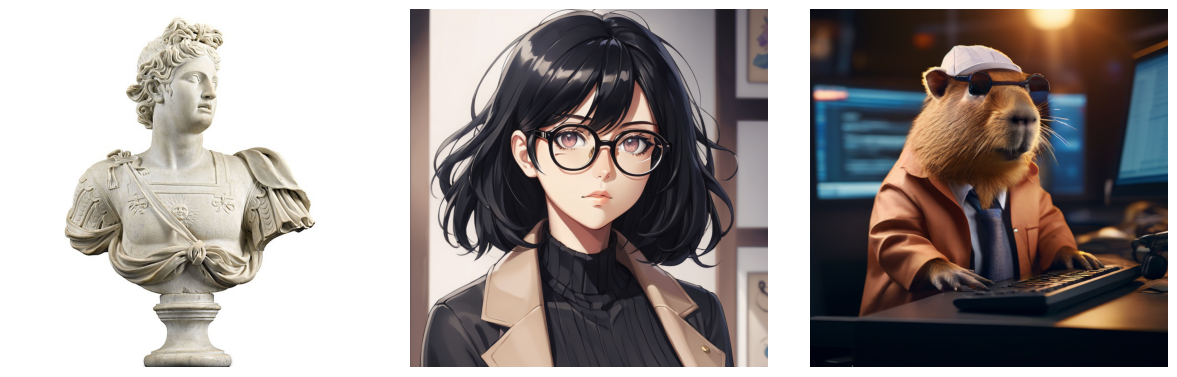

In [8]:
ip_adapter_images = [
    load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/statue.png"),
    load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/ip_mask_girl1.png"),
    load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/capybara.png"),
]

prompts = [
    'a statue',
    'a beautiful anime',
    'a capybara',
]

show_images(ip_adapter_images, figsize=(12, 4))

In [9]:
width=768
height=768
generator = torch.Generator(device="cpu").manual_seed(17)
controlnets_weights = [0.5, 0.5]
controlnets_startstop = [(0.0, 1.0), (0.2, 0.8)]
image = [qrcode_img, qrcode_img]

out_images = []
for prompt, ip_adapter_image in zip(prompts, ip_adapter_images):
    res = pipe(
        prompt, 
        ip_adapter_image=ip_adapter_image,
        image=image,
        controlnet_conditioning_scale=controlnets_weights, 
        controlnet_guidance=controlnets_startstop,
        num_inference_steps=30, 
        width=width, 
        height=height,
        generator=generator,
    )
    out_images += res.images

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

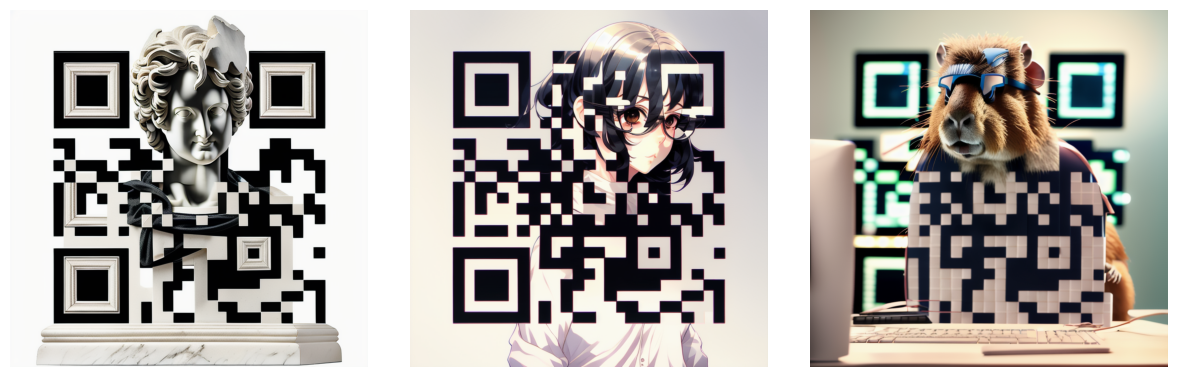

In [10]:
show_images(out_images, figsize=(12, 4))